# <h1> Project 1

Gradient - based optimization and differentiable programming

Pole - Cart Balancing Controller Design with Neural Network and Gradient Descent.

In [837]:
# Importing Libraries
import logging
import numpy as np
import torch as t
import torch.nn as nn
from torch import optim
import matplotlib.pyplot as plt
logger = logging.getLogger(__name__)

In [838]:
# Setting up State - Space Matrices for Pole - Cart System
M = 0.5
m = 0.2
b = 0.1
I = 0.006
g = 9.8
l = 0.3
p = I*(M+m)+M*m*(l**2)

In [839]:
A = t.tensor([[1,0.009991,0.0001336,4.453e-07],
             [0,0.9982,0.02672,0.0001336],
             [0,-2.272e-05,1.002,0.01001],
             [0,-0.004544,0.3119,1.002]]).float()
B = t.tensor([[9.086e-05],
              [0.01817],
              [0.0002272],
              [0.04544]]).float()
C = t.tensor([[1,0,0,0],
              [0,0,1,0]]).float()
D = t.tensor([[0],[0]]).float()

In [840]:
xg = t.matmul(B,t.tensor([0.4])).reshape(4,1)

In [841]:
class Dynamics(nn.Module):
    def __init__(self):
        super(Dynamics, self).__init__()
    @staticmethod
    def forward(state,k,ref):
        kx = t.tensor([ref]) - t.matmul(k.reshape(1,4),state.reshape(4,1))
        dx = t.matmul(B,kx).reshape(4,1)
        state = t.matmul(A,state.reshape(4,1)) + dx
        return state.reshape(1,4)

In [842]:
class Controller(nn.Module):

    def __init__(self, dim_input, dim_hidden, dim_output):
        """
        dim_input: # of system states
        dim_output: # of actions
        dim_hidden: up to you
        """
        super(Controller, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(dim_input,dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden,dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden,dim_output)
        )

    def forward(self, state):
        k = self.network(state)
        return k

In [843]:
class Simulation(nn.Module):

    def __init__(self, controller, dynamics, T,ref):
        super(Simulation, self).__init__()
        self.state = self.initialize_state()
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.ref = ref
        self.action_trajectory = []
        self.state_trajectory = []

    def forward(self, state):
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(T):
            action = self.controller.forward(state)
            state = self.dynamics.forward(state,action,ref)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state,ref)

    @staticmethod
    def initialize_state():
        state = [0.,0.,0.,0.]
        return t.tensor(state,requires_grad=False).float()
    def error(self,state,ref):
        return (state[0][0]-ref)**2 + state[0][2]**2

In [844]:
class Optimize:
    def __init__(self, simulation):
        self.simulation = simulation
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.LBFGS(self.parameters, lr=0.01)


    def step(self):
        def closure():
            loss = self.simulation(self.simulation.state)
            self.optimizer.zero_grad()
            loss.backward()
            return loss
        self.optimizer.step(closure)
        return closure()


    def train(self, epochs):
        loss_vec = []
        for epoch in range(epochs):
            loss = self.step()
            loss_vec.append(loss)
            print('[%d] loss: %.3f' % (epoch + 1, loss))
            if epoch%5==0:
                self.visualize()
        return loss_vec

    def visualize(self):
        data = np.array([self.simulation.state_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
        x = data[:,0,0]
        y = data[:,0,2]
        fig,ax = plt.subplots()
        ax1 = ax.twinx()
        ax.plot(x,color = 'tab:red',label='Cart')
        ax.set_ylabel('Meters (m)',color = 'tab:red')
        ax.legend()
        ax1.plot(y,color = 'tab:blue',label = 'Pole')
        ax1.set_ylabel('Radians (rad)',color = 'tab:blue')
        ax1.legend()
        plt.title('Step Response')
        plt.show()

[1] loss: 599325.875


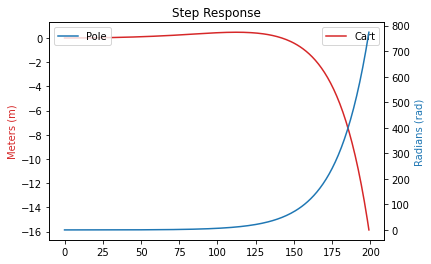

[2] loss: 415825.188
[3] loss: 273683.688
[4] loss: 195091.625
[5] loss: 143801.703


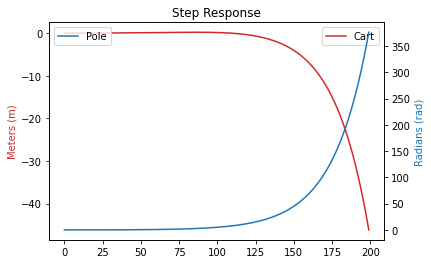

[6] loss: 105475.336
[7] loss: 75126.617
[8] loss: 53460.477
[9] loss: 38703.465


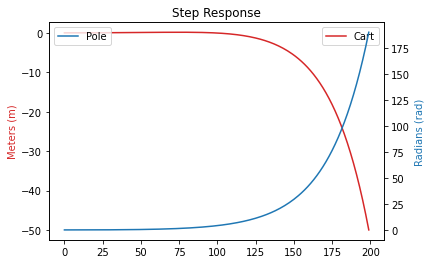

[10] loss: 27460.008


In [845]:
dim_input = 4
dim_output = 4
dim_hidden = 10
ref = 0.4
T = 200
d = Dynamics()  # define dynamics
c = Controller(dim_input, dim_hidden, dim_output)  # define controller
s = Simulation(c,d, T,ref)  # define simulation
o = Optimize(s)  # define optimizer
error = o.train(10)

Text(0.5, 1.0, 'Error Convergence')

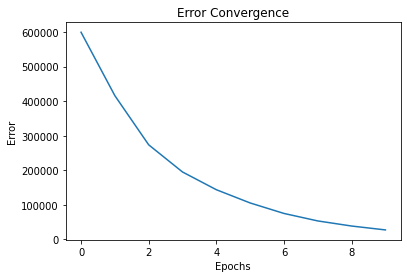

In [846]:
plt.plot(t.tensor(error).detach().numpy())
plt.ylabel('Error')
plt.xlabel('Epochs')
plt.title('Error Convergence')

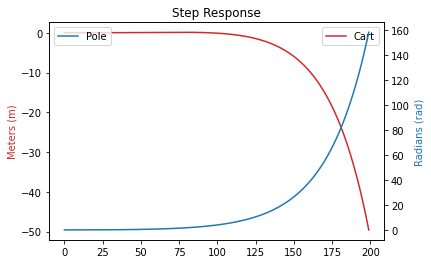

In [847]:
o.visualize()